In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

path = "C:/Users/itataurov.KORECAPITAL/Desktop/ccxt_data/data_parsed/1d/technical/binance/joined/binance_perps_joined.parquet"

df = pd.read_parquet(path, engine='pyarrow')
df = df.sort_values(by=['datetime'])
df.datetime = pd.to_datetime(df.datetime)

In [2]:
# 1) Compute each coin’s true days since listing (using its first-ever timestamp)
first_list = df.groupby('symbol')['datetime'].transform('min')
df['days_since_list'] = (df['datetime'] - first_list).dt.days
df['signal'] = np.where(df['days_since_list'] < 80, -1, 0)

# Event study

We want to compare the avg cumulative return of a newly listed coin and compare it the avg cumulative return of all coins for the same period.

In [3]:
# 2) Filter raw data to only the last n months
n_months_ago = pd.Timestamp.now() - pd.DateOffset(months=36)
df = df[df['datetime'] >= n_months_ago].copy()

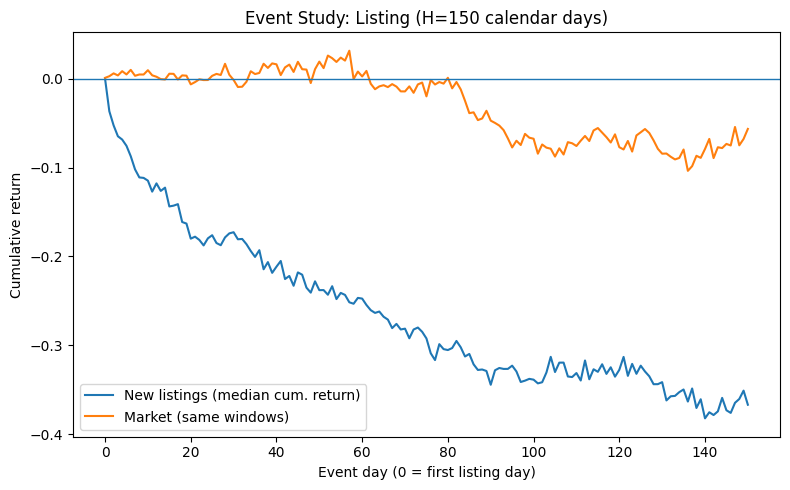

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Load & prep ---
path = "C:/Users/itataurov.KORECAPITAL/Desktop/ccxt_data/data_parsed/1d/technical/binance/joined/binance_perps_joined.parquet"
df = pd.read_parquet(path, engine='pyarrow')
df = df.sort_values('datetime')
df['datetime'] = pd.to_datetime(df['datetime'])

# Pivot to Prices (Date x Symbol)
prices = df.pivot(index='datetime', columns='symbol', values='close').sort_index()

# Daily returns
rets = prices.pct_change().dropna(how='all')

# Listing dates per symbol (first date we have a price)
first_dates = prices.apply(lambda s: s.first_valid_index())

# --- Parameters ---
H = 150 # horizon in calendar days after listing to track
min_len = 0  # require at least 10 days to include a coin (keep it simple)

# Containers for event-aligned cumulative returns
event_curves = []
benchmark_curves = []

for sym, start_date in first_dates.items():
    if pd.isna(start_date):
        continue

    # Select calendar window [start_date, start_date+H]
    end_date = start_date + pd.Timedelta(days=H)
    window_idx = rets.index[(rets.index >= start_date) & (rets.index <= end_date)]
    if len(window_idx) < min_len:
        continue

    # Coin-specific returns over the window (fill NA with 0 for simplicity)
    coin_r = rets.loc[window_idx, sym].fillna(0.0)
    coin_cum = (1.0 + coin_r).cumprod() - 1.0
    # Reindex to event time: 0..T-1
    coin_cum.index = np.arange(len(coin_cum))
    event_curves.append(coin_cum)

    # Equal-weight market over the *same calendar dates* as a benchmark
    mkt_r = rets.loc[window_idx].mean(axis=1, skipna=True)
    mkt_cum = (1.0 + mkt_r).cumprod() - 1.0
    mkt_cum.index = np.arange(len(mkt_cum))
    benchmark_curves.append(mkt_cum)

# Average across events (align by inner index)
if event_curves and benchmark_curves:
    # Concatenate with axis=1 and take mean row-wise
    avg_event = pd.concat(event_curves, axis=1).median(axis=1)
    avg_bench = pd.concat(benchmark_curves, axis=1).median(axis=1)
else:
    raise ValueError("No valid events found. Check data coverage or adjust H/min_len.")

# --- Plot ---
plt.figure(figsize=(8,5))
plt.plot(avg_event.index, avg_event.values, label="New listings (median cum. return)")
plt.plot(avg_bench.index, avg_bench.values, label="Market (same windows)")
plt.axhline(0, linewidth=1)
plt.xlabel("Event day (0 = first listing day)")
plt.ylabel("Cumulative return")
plt.title(f"Event Study: Listing (H={H} calendar days)")
plt.legend()
plt.tight_layout()
plt.show()


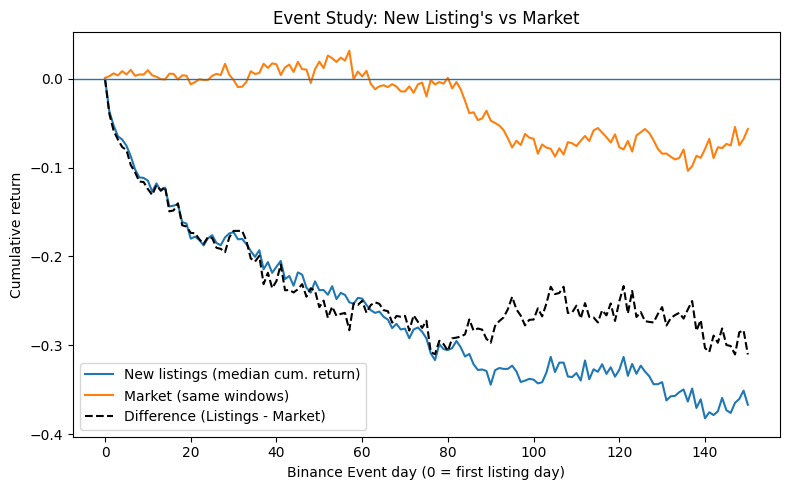

In [5]:
# --- Plot ---
plt.figure(figsize=(8,5))
plt.plot(avg_event.index, avg_event.values, label="New listings (median cum. return)")
plt.plot(avg_bench.index, avg_bench.values, label="Market (same windows)")

# Difference: new listings minus market
diff = avg_event - avg_bench
plt.plot(diff.index, diff.values, label="Difference (Listings - Market)", color="black", linestyle="--")

plt.axhline(0, linewidth=1)
plt.xlabel("Binance Event day (0 = first listing day)")
plt.ylabel("Cumulative return")
plt.title(f"Event Study: New Listing's vs Market")
plt.legend()
plt.tight_layout()
plt.show()

# Equal weight backtest, rolling hedge

C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_12492\505372736.py:47: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df["weight"] = df.groupby("datetime", group_keys=False).apply(_equal_long)


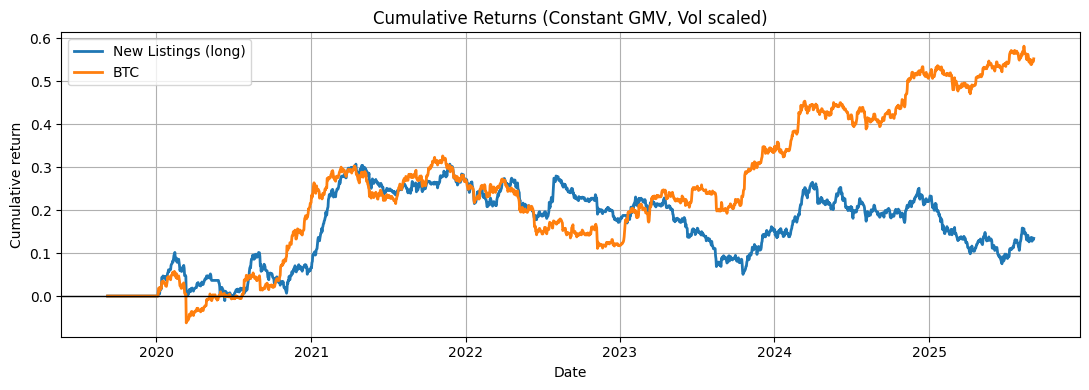

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# ---------------- 1. Load & prep ----------------
df = pd.read_parquet(
    "C:/Users/itataurov.KORECAPITAL/Desktop/ccxt_data/data_parsed/1d/technical/binance/joined/binance_perps_joined.parquet",
    engine="pyarrow"
)
df = df.sort_values(["datetime", "symbol"]).copy()
df["datetime"] = pd.to_datetime(df["datetime"])

# ---------------- 2. Days since listing ----------------
first_list = df.groupby("symbol")["datetime"].transform("min")
df["days_since_list"] = (df["datetime"] - first_list).dt.days

# ---------------- 3. Returns ----------------
if "ret" not in df.columns:
    df["ret"] = df.groupby("symbol")["close"].pct_change()

df['dollar_volume'] = df['volume'] * df['close']
df['dollar_volume_slowed'] = df.groupby('symbol')['dollar_volume'].transform(lambda x: x.ewm(span=30, adjust=False).mean())
df[df.dollar_volume_slowed>1e7]

# ---------------- 4. Equal-weight long signals ----------------
# Rule: long all coins within 80 days of listing (was -1 before, now +1/n)
def _equal_long(day):
    longs = day["days_since_list"] < 80
    n = longs.sum()
    return pd.Series(np.where(longs, 1.0 / n, 0.0) if n > 0 else np.zeros(len(day)), index=day.index)

# def _dollarvol_short(day):
#     vols = day["dollar_volume_slowed"].clip(lower=0)  # no negatives
#     total = vols.sum()
#     if total > 0:
#         return vols / total   # positive weights, sum to 1
#     else:
#         return pd.Series(np.zeros(len(day)), index=day.index)
    
# def _dollarvol_short(day, alpha=0.5, adv_floor=1e6):
#     vols = day["dollar_volume_slowed"].clip(lower=adv_floor)
#     tilted = vols ** (-alpha)   # alpha < 1 dampens the inversion
    return tilted / tilted.sum()
    

df["weight"] = df.groupby("datetime", group_keys=False).apply(_equal_long)

# ---------------- 5. Wide pivot ----------------
weights = df.pivot(index="datetime", columns="symbol", values="weight").fillna(0.0)
rets    = df.pivot(index="datetime", columns="symbol", values="ret").fillna(0.0)

# Hard-code BTC
BTC_COL = "BTC"
if BTC_COL not in rets.columns:
    raise ValueError(f"{BTC_COL} not found in symbols: {rets.columns[:10].tolist()}...")

# ---------------- 6. Portfolio returns ----------------
# Use yesterday's weights × today's returns (no look-ahead)
alt_port_ret = (weights.shift(1) * rets).sum(axis=1).rename("alt_port_ret")
btc_ret = rets[BTC_COL].rename("btc_ret")
btc_ret = btc_ret

# funding returns 
funding = df.pivot(index="datetime", columns="symbol", values="fundingRate").fillna(0.0)
long_alt_funding_pnl = -(weights.shift(1) * funding).sum(axis=1).rename("alt_funding_pnl")
long_btc_funding_pnl = -funding[BTC_COL].rename("btc_funding_pnl")

# vol scale both to 10% ann.
def vol_scale(port_ret):
    VT = 0.10 
    w_scaler = VT / (port_ret.ewm(halflife=20, adjust=False, min_periods=120).std().shift(1) * np.sqrt(365))
    port_ret = port_ret.replace(np.nan, 0) * w_scaler.replace(np.nan, 0).clip(0,1)

    return port_ret#.iloc[port_ret.index > '2023-03-01']

# adjust for funding
alt_port_ret = alt_port_ret - long_alt_funding_pnl
btc_ret = btc_ret + long_btc_funding_pnl

# vol scale
alt_port_ret = vol_scale(alt_port_ret)
btc_ret = vol_scale(btc_ret)

# ---------------- 7. Cumulative arithmetic returns ----------------
cum_alt = (alt_port_ret).cumsum().rename("New Listings (equal weight)")
cum_btc = (btc_ret).cumsum().rename("BTC")

# ---------------- 8. Plot ----------------
plt.figure(figsize=(11, 4))
plt.plot(cum_alt.index, cum_alt.values, label="New Listings (long)", lw=2)
plt.plot(cum_btc.index, cum_btc.values, label="BTC", lw=2)
plt.axhline(0, lw=1, color="black")
plt.title("Cumulative Returns (Constant GMV, Vol scaled)")
plt.xlabel("Date")
plt.ylabel("Cumulative return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
df.columns

Index(['symbol', 'datetime', 'open', 'high', 'low', 'close', 'volume',
       'mkt_cap', 'fundingRate', 'oi', 'ls_ratio', 'longs_pct',
       'buy_volume_perp', 'total_volume_perp', 'buy_trades_perp',
       'total_trades_perp', 'spot_close', 'buy_volume_spot',
       'total_volume_spot', 'buy_trades_spot', 'total_trades_spot',
       'predicted_funding_rate', 'short_liquidation_volume',
       'long_liquidation_volume', 'days_since_list', 'ret', 'dollar_volume',
       'dollar_volume_slowed', 'weight'],
      dtype='object')

In [8]:
# say we can do 100k per position, thats 50*100k = 5M short book, 5*1.3 hedge, 11.5M GMV

In [9]:
last_weights = weights.iloc[-1]
last_weights = last_weights[last_weights > 0].sort_values(ascending=False)
last_weights

symbol
A2Z        0.018868
AIN        0.018868
AIO        0.018868
ALL        0.018868
ARIA       0.018868
BAS        0.018868
BTR        0.018868
BULLA      0.018868
C          0.018868
CARV       0.018868
CROSS      0.018868
CUDIS      0.018868
CVX        0.018868
DAM        0.018868
DMC        0.018868
ERA        0.018868
ESPORTS    0.018868
F          0.018868
H          0.018868
HEMI       0.018868
ICNT       0.018868
IDOL       0.018868
IN         0.018868
LINEA      0.018868
MITO       0.018868
MYX        0.018868
NAORIS     0.018868
NEWT       0.018868
OL         0.018868
PLAY       0.018868
PROVE      0.018868
PTB        0.018868
PUMP       0.018868
Q          0.018868
SAHARA     0.018868
SAPIEN     0.018868
SLP        0.018868
SOMI       0.018868
TA         0.018868
TAC        0.018868
TAG        0.018868
TAKE       0.018868
TANSSI     0.018868
TOWNS      0.018868
TREE       0.018868
USELESS    0.018868
VELVET     0.018868
WLFI       0.018868
XNY        0.018868
XPL        0.

In [10]:
# df[(df.datetime==df.datetime.max()) & (df.symbol.isin(last_weights.index.values))]['dollar_volume'].sort_values(ascending=False).describe()

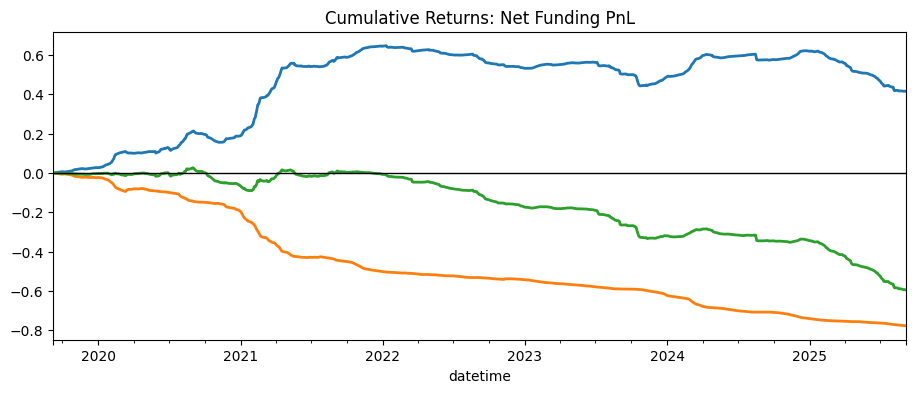

In [11]:
(-1 * long_alt_funding_pnl).cumsum().plot(figsize=(11,4), lw=2, title="Cumulative Returns: Alt Funding PnL")
long_btc_funding_pnl.cumsum().plot(figsize=(11,4), lw=2, title="Cumulative Returns: BTC Funding PnL")

net_funding_pnl = - long_alt_funding_pnl + 1.3*long_btc_funding_pnl
net_funding_pnl.cumsum().plot(figsize=(11,4), lw=2, title="Cumulative Returns: Net Funding PnL")
plt.axhline(0, lw=1, color="black")

# Txn costs


In [12]:
COST = 0.0015  # 15bp

# Rebalanced weights (post-return, pre-rebalance)
port_ret = (weights.shift(1) * rets).sum(axis=1)
weights_pre_rebal = weights.shift(1) * (1 + rets)
weights_pre_rebal = weights_pre_rebal.div((1 + port_ret), axis=0)

# Daily turnover (gross change in weights)
turnover = (weights - weights_pre_rebal).abs().sum(axis=1).rename("turnover")

# Split long vs short
turnover_long  = ((weights - weights_pre_rebal) * (weights > 0)).abs().sum(axis=1)
turnover_short = ((weights - weights_pre_rebal) * (weights < 0)).abs().sum(axis=1)

# Fee PnL
fee_pnl = -(turnover * COST).rename("fee_pnl")


# short book size

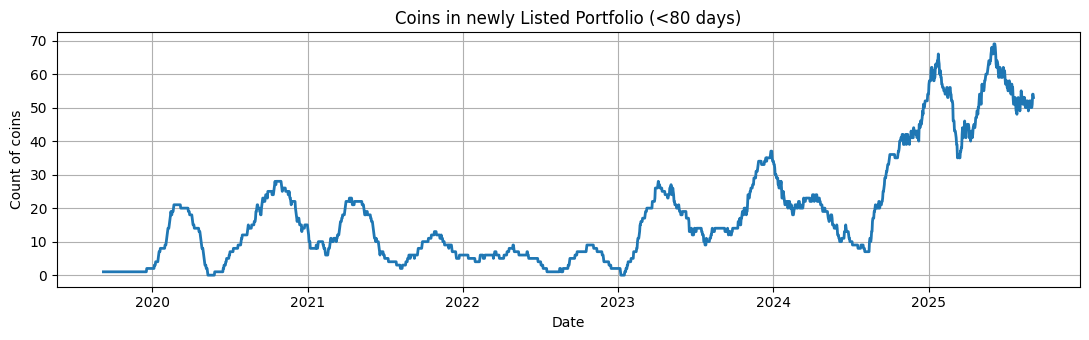

In [13]:
# ---------------- 9. Count of coins in new-listings portfolio ----------------
coin_count = (df['days_since_list'] < 80).groupby(df['datetime']).sum()
coin_count = coin_count.rename("newly_listed_count")

plt.figure(figsize=(11, 3.5))
plt.plot(coin_count.index, coin_count.values, lw=2)
plt.title("Coins in newly Listed Portfolio (<80 days)")
plt.xlabel("Date")
plt.ylabel("Count of coins")
plt.grid(True)
plt.tight_layout()
plt.show()


# hedge ratio

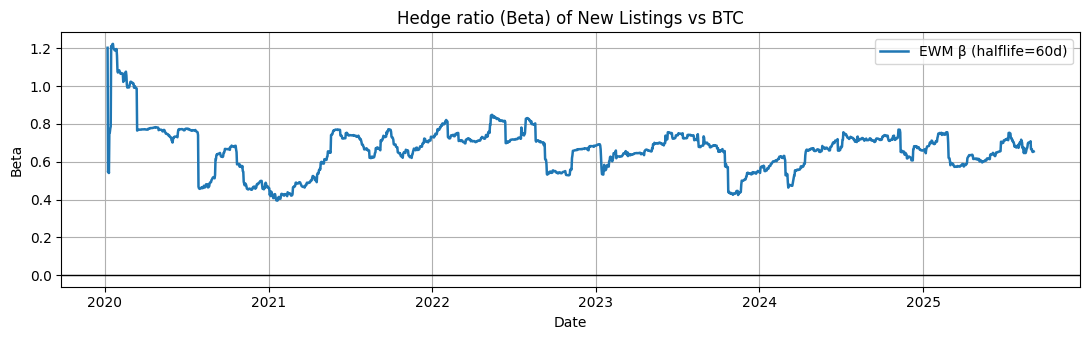

In [14]:
# ---------------- 9. Rolling beta (EWM halflife=60 days) ----------------
HL = 60
MINP = 20  # minimum periods for stability

cov_ab = alt_port_ret.ewm(halflife=HL, adjust=False, min_periods=MINP).cov(btc_ret)
var_b  = btc_ret.ewm(halflife=HL, adjust=False, min_periods=MINP).var()

beta_raw = cov_ab / var_b
beta = beta_raw.shift(1).rename("beta")  # lag 1 day to avoid look-ahead

# ---------------- 10. Plot beta ----------------
plt.figure(figsize=(11, 3.5))
plt.plot(beta.index, beta.values, lw=1.8, label=f"EWM β (halflife={HL}d)")
plt.axhline(0, color="black", lw=1)
plt.title("Hedge ratio (Beta) of New Listings vs BTC")
plt.xlabel("Date")
plt.ylabel("Beta")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Funding PNL (unscaled)

<Axes: xlabel='datetime'>

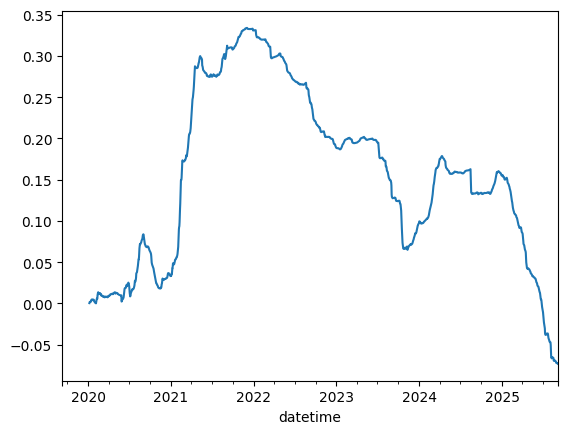

In [15]:
(- long_alt_funding_pnl + beta*long_btc_funding_pnl).cumsum().plot()

<Axes: title={'center': 'Cumulative Returns: Hedged New Listings vs BTC'}, xlabel='datetime'>

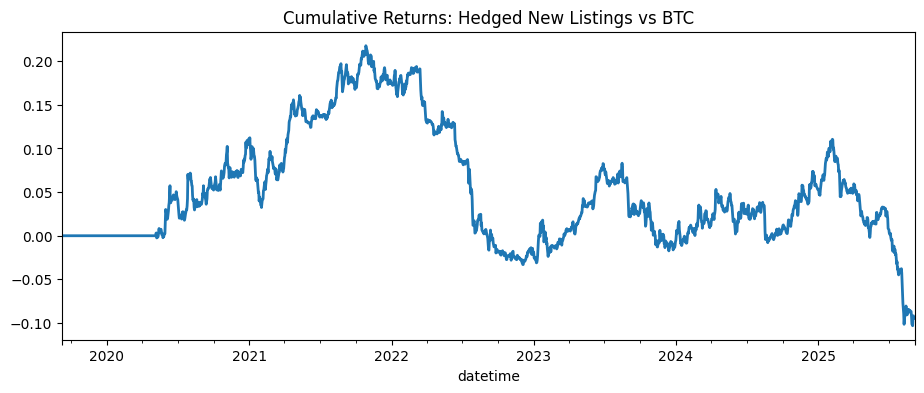

In [16]:
# ex-ante vol scale to 10% ann.
VT = 0.10 

portfolio_return = (- alt_port_ret + btc_ret * beta + fee_pnl - long_alt_funding_pnl + beta*long_btc_funding_pnl) 
w_scaler = VT / (portfolio_return.ewm(halflife=20, adjust=False, min_periods=120).std().shift(1) * np.sqrt(365))

portfolio_return = portfolio_return.replace(np.nan, 0) * w_scaler.replace(np.nan, 0).clip(lower=0, upper=1)
portfolio_return.cumsum().rename("Hedged New Listings (equal weight)").plot(figsize=(11,4), lw=2, title="Cumulative Returns: Hedged New Listings vs BTC")

<Axes: xlabel='datetime'>

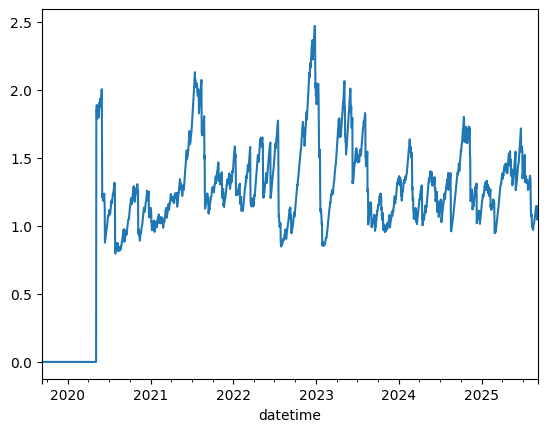

In [17]:
w_scaler.replace(np.nan, 0).plot()

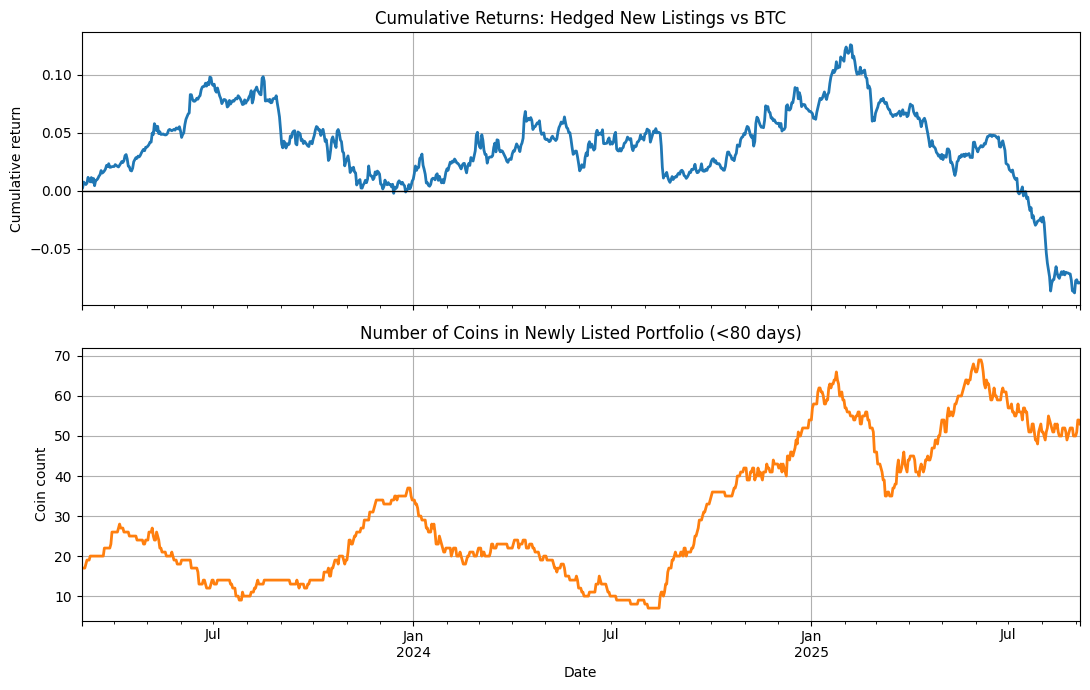

In [18]:
# ---------------- 11. Hedged equity curve ----------------

# Apply the same cutoff as df
# portfolio_return = portfolio_return.loc[portfolio_return.index > '2020-03-01']


portfolio_return =  portfolio_return.loc[portfolio_return.index > '2023-03-01']

hedged_cum = portfolio_return.cumsum().rename("Hedged New Listings (equal weight)")

# ---------------- 12. Coin count ----------------
coin_count = (df['days_since_list'] < 80).groupby(df['datetime']).sum()
coin_count = coin_count.loc[coin_count.index > '2023-03-01']
coin_count = coin_count.rename("newly_listed_count")

# ---------------- 13. Plot stacked ----------------
fig, axes = plt.subplots(2, 1, figsize=(11, 7), sharex=True)

# Top: hedged cumulative return
hedged_cum.plot(ax=axes[0], lw=2, color="tab:blue")
axes[0].axhline(0, color="black", lw=1)
axes[0].set_title("Cumulative Returns: Hedged New Listings vs BTC")
axes[0].set_ylabel("Cumulative return")
axes[0].grid(True)

# Bottom: # of coins
coin_count.plot(ax=axes[1], lw=2, color="tab:orange")
axes[1].set_title("Number of Coins in Newly Listed Portfolio (<80 days)")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Coin count")
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [19]:
# ---------------- 14. Performance statistics ----------------
daily_ret = portfolio_return.dropna()
n_days = len(daily_ret)
if n_days == 0:
    raise ValueError("No returns after filtering; check your date cutoff.")

# Assumption: 365 trading days per year for crypto
ann_factor = 365

# CAGR: arithmetic cum sum view, so we convert final equity to CAGR
final_equity = 1 + daily_ret.cumsum().iloc[-1]
years = (daily_ret.index[-1] - daily_ret.index[0]).days / 365
cagr = final_equity**(1/years) - 1 if years > 0 else np.nan

# Annualized volatility
vol = daily_ret.std() * np.sqrt(ann_factor)

# Sharpe ratio
sharpe = (daily_ret.mean() / daily_ret.std()) * np.sqrt(ann_factor)

# Max drawdown (on equity curve)
equity_curve = (1 + daily_ret.cumsum())
running_max = equity_curve.cummax()
drawdown = equity_curve / running_max - 1
max_dd = drawdown.min()

print(f"CAGR:   {cagr:.2%}")
print(f"Vol:    {vol:.2%}")
print(f"Sharpe: {sharpe:.2f}")
print(f"Max DD: {max_dd:.2%}")


CAGR:   -3.22%
Vol:    7.98%
Sharpe: -0.39
Max DD: -18.98%


# Parameter sensitivity

Hedged Sharpe: -0.02
Hedged Sharpe: -0.01
Hedged Sharpe: -0.01
Hedged Sharpe: -0.01
Hedged Sharpe: -0.01
Hedged Sharpe: -0.01
Hedged Sharpe: -0.01
Hedged Sharpe: -0.01
Hedged Sharpe: -0.02
Hedged Sharpe: -0.02
Hedged Sharpe: -0.02
Hedged Sharpe: -0.02
Hedged Sharpe: -0.02
Hedged Sharpe: -0.02
Hedged Sharpe: -0.02
Hedged Sharpe: -0.02
Hedged Sharpe: -0.03
Hedged Sharpe: -0.03
Hedged Sharpe: -0.03
Hedged Sharpe: -0.03
Hedged Sharpe: -0.03
Hedged Sharpe: -0.03
Hedged Sharpe: -0.03
Hedged Sharpe: -0.03
Hedged Sharpe: -0.03
Hedged Sharpe: -0.03
Hedged Sharpe: -0.03
Hedged Sharpe: -0.03
Hedged Sharpe: -0.03
Hedged Sharpe: -0.03
Hedged Sharpe: -0.03
Hedged Sharpe: -0.03
Hedged Sharpe: -0.03
Hedged Sharpe: -0.03
Hedged Sharpe: -0.03
Hedged Sharpe: -0.03
Hedged Sharpe: -0.03
Hedged Sharpe: -0.03
Hedged Sharpe: -0.03
Hedged Sharpe: -0.03
Hedged Sharpe: -0.03
Hedged Sharpe: -0.03
Hedged Sharpe: -0.03
Hedged Sharpe: -0.03
Hedged Sharpe: -0.03
Hedged Sharpe: -0.03
Hedged Sharpe: -0.03
Hedged Sharpe

Text(0.5, 0, 'EWM Halflife (days)')

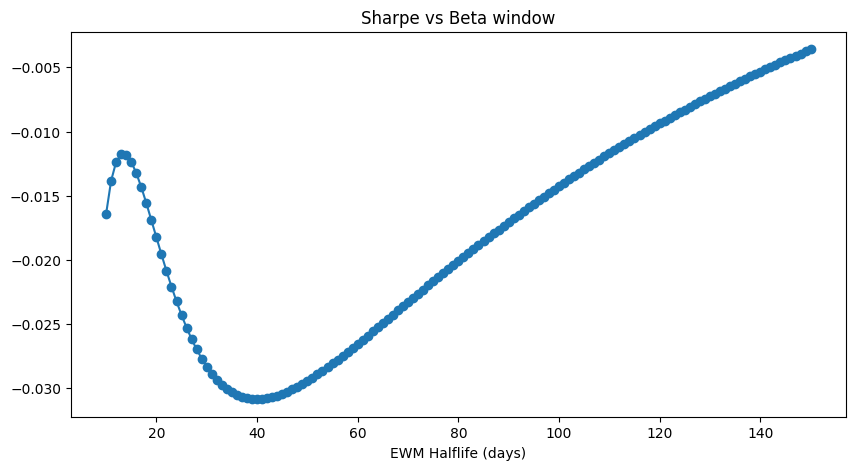

In [20]:

halflives = []
sharpes = []

for HL in [i for i in range(10, 151, 1)]:
    MINP = 20  # minimum periods for stability

    cov_ab = alt_port_ret.ewm(halflife=HL, adjust=False, min_periods=MINP).cov(btc_ret)
    var_b  = btc_ret.ewm(halflife=HL, adjust=False, min_periods=MINP).var()

    beta_raw = cov_ab / var_b
    beta = beta_raw.shift(1).rename("beta")  # lag 1 day to avoid look-ahead

    # ---------------- 11. Hedged equity curve ----------------
    hedged_ret = (- alt_port_ret + btc_ret * beta + fee_pnl - long_alt_funding_pnl + beta*long_btc_funding_pnl) 
    # Apply the same cutoff as df
    hedged_ret = hedged_ret.loc[hedged_ret.index > '2023-03-01']

    # vol scale to 10%
    hedged_ret = hedged_ret * (0.10 / (hedged_ret.rolling(window=30, min_periods=10).std() * np.sqrt(365)))

    # hedged_ret.cumsum().rename("Hedged New Listings (equal weight)").plot(figsize=(11,4), lw=2, title=f"Cumulative Returns: Hedged New Listings vs BTC (HL={HL}d)")

    sharpe = (hedged_ret.mean() / hedged_ret.std()) * np.sqrt(ann_factor)

    print(f"Hedged Sharpe: {sharpe:.2f}")
    halflives.append(HL)
    sharpes.append(sharpe)


# plot
plt.figure(figsize=(10,5))
plt.plot(halflives, sharpes, marker='o')
plt.title("Sharpe vs Beta window")
plt.xlabel("EWM Halflife (days)")

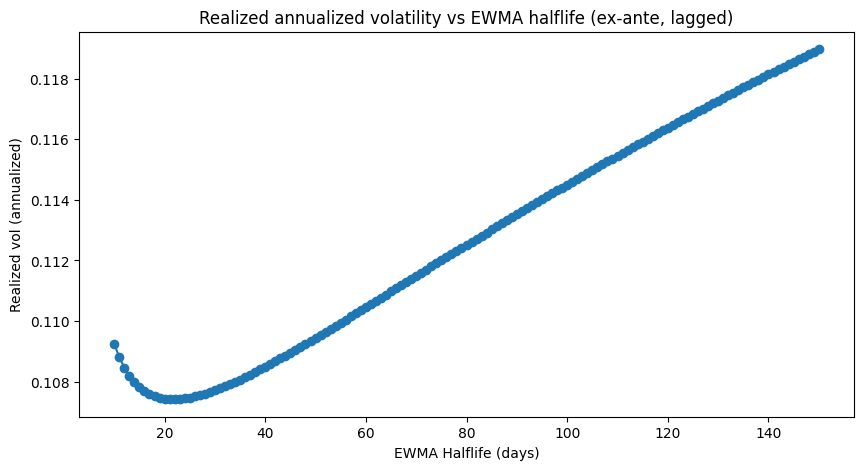

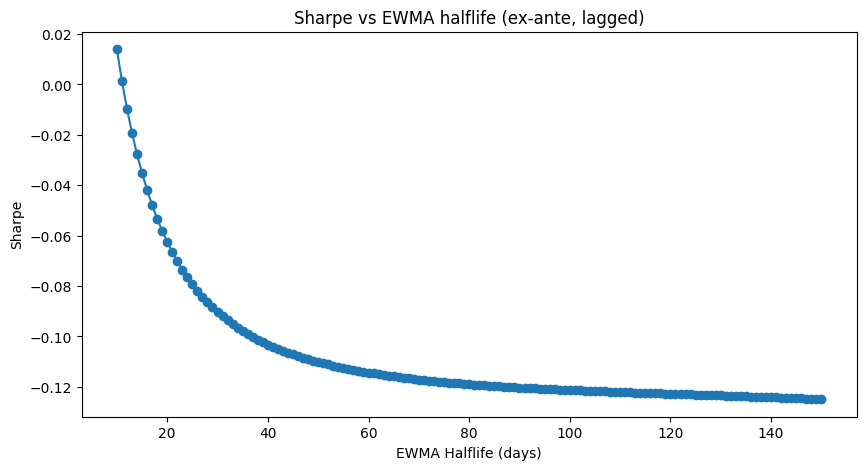

In [21]:
halflives = []
realized_vols = []
sharpes = []

ANN = 365  # crypto daily
TARGET_ANN_VOL = 0.10
TARGET_D_VOL = TARGET_ANN_VOL / np.sqrt(ANN)
MINP = 20
MAX_LEV = 5.0  # cap to avoid crazy leverage

# 1) Ex-ante beta (you already lag it by 1 day—good)
cov_ab = alt_port_ret.ewm(halflife=90, adjust=False, min_periods=MINP).cov(btc_ret)
var_b  = btc_ret.ewm(halflife=90, adjust=False, min_periods=MINP).var()
beta_raw = cov_ab / var_b
beta = beta_raw.shift(1).rename("beta")

# 2) Base (unscaled) strategy return = unit notional
base_ret = (
    -alt_port_ret
    + btc_ret * beta
    + fee_pnl
    - long_alt_funding_pnl
    + beta * long_btc_funding_pnl
)

base_ret = base_ret.loc[base_ret.index > '2023-03-01']

for VOL_TARGET_HALFLIFE in range(10, 151):
    # 3) Ex-ante sigma: EWMA of base_ret, lagged by 1 day
    sigma_d = base_ret.ewm(halflife=VOL_TARGET_HALFLIFE, adjust=False, min_periods=MINP).std().shift(1)

    # 4) Position size (daily) = target_d_vol / ex-ante sigma_d, clipped
    scaler = (TARGET_D_VOL / sigma_d).clip(lower=0, upper=MAX_LEV)

    # Align and drop NaNs where scaler isn’t ready yet
    s = scaler.reindex(base_ret.index)
    ret_scaled = (base_ret * s).dropna()

    # 5) Metrics
    mu = ret_scaled.mean()
    sd = ret_scaled.std()
    realized_vol_ann = sd * np.sqrt(ANN)
    sharpe = (mu / sd) * np.sqrt(ANN)

    halflives.append(VOL_TARGET_HALFLIFE)
    realized_vols.append(realized_vol_ann)
    sharpes.append(sharpe)

# Plot realized vol vs halflife
plt.figure(figsize=(10,5))
plt.plot(halflives, realized_vols, marker='o')
plt.title("Realized annualized volatility vs EWMA halflife (ex-ante, lagged)")
plt.xlabel("EWMA Halflife (days)")
plt.ylabel("Realized vol (annualized)")

# Optional: also plot Sharpe vs halflife
plt.figure(figsize=(10,5))
plt.plot(halflives, sharpes, marker='o')
plt.title("Sharpe vs EWMA halflife (ex-ante, lagged)")
plt.xlabel("EWMA Halflife (days)")
plt.ylabel("Sharpe")
plt.show()


# 

C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_12492\2411872833.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df["weight"] = df.groupby("datetime", group_keys=False).apply(_equal_long)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_12492\2411872833.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df["weight"] = df.groupby("datetime", group_keys=False).apply(_equal_long)
C:\Users\i

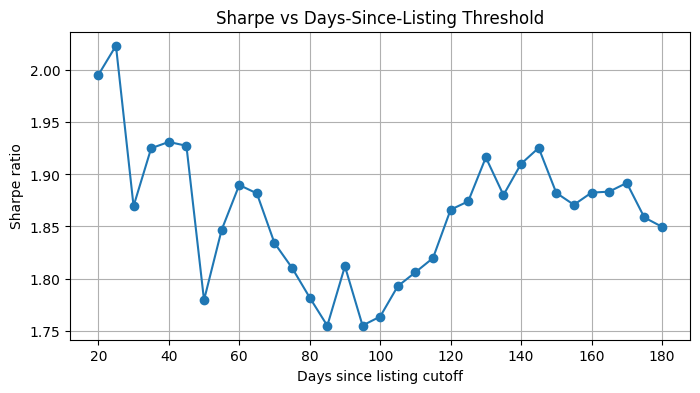

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def run_strategy(max_days):
    """
    Run the strategy with a cutoff of max_days since listing.
    Returns daily portfolio return series.
    """
    # --- Equal-weight signals ---
    def _equal_long(day):
        longs = day["days_since_list"] < max_days
        n = longs.sum()
        return pd.Series(np.where(longs, 1.0 / n, 0.0) if n > 0 else np.zeros(len(day)), index=day.index)

    df["weight"] = df.groupby("datetime", group_keys=False).apply(_equal_long)

    # --- Pivot ---
    weights = df.pivot(index="datetime", columns="symbol", values="weight").fillna(0.0)
    rets    = df.pivot(index="datetime", columns="symbol", values="ret").fillna(0.0)
    funding = df.pivot(index="datetime", columns="symbol", values="fundingRate").fillna(0.0)

    # Portfolio ret (lagged weights)
    alt_port_ret = (weights.shift(1) * rets).sum(axis=1)
    long_alt_funding_pnl = -(weights.shift(1) * funding).sum(axis=1)

    # BTC legs
    btc_ret = rets[BTC_COL]
    long_btc_funding_pnl = -funding[BTC_COL]

    # Rolling beta
    cov_ab = alt_port_ret.ewm(halflife=HL, adjust=False, min_periods=MINP).cov(btc_ret)
    var_b  = btc_ret.ewm(halflife=HL, adjust=False, min_periods=MINP).var()
    beta = (cov_ab / var_b).shift(1)

    # Hedged portfolio return
    port_ret = (- alt_port_ret + btc_ret * beta - long_alt_funding_pnl + beta * long_btc_funding_pnl)

    # Vol scaling
    w_scaler = VT / (port_ret.ewm(halflife=20, adjust=False, min_periods=120).std().shift(1) * np.sqrt(365))
    port_ret = port_ret.replace(np.nan, 0) * w_scaler.replace(np.nan, 0).clip(0,1)

    return port_ret.iloc[port_ret.index > '2023-03-01']

# ---------------- Param sweep ----------------
param_range = range(20, 181, 5)  # e.g. 20, 40, ..., 180
results = {}

for max_days in param_range:
    pr = run_strategy(max_days)
    ann_ret = pr.mean() * 365
    ann_vol = pr.std() * np.sqrt(365)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan
    results[max_days] = sharpe

# ---------------- Plot ----------------
plt.figure(figsize=(8,4))
plt.plot(list(results.keys()), list(results.values()), marker="o")
plt.title("Sharpe vs Days-Since-Listing Threshold")
plt.xlabel("Days since listing cutoff")
plt.ylabel("Sharpe ratio")
plt.grid(True)
plt.show()


In [23]:
w

NameError: name 'w' is not defined